# Evaluation

In [1]:
from six.moves import cPickle as pickle
from matplotlib import pyplot
import numpy as np
import torch
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
%config InlineBackend.rc = {'figure.facecolor': (1, 1, 1, 1)}

In [2]:
DATASET = 'census'
with open('results/test/{}.eval.pkl'.format(DATASET), 'rb') as f:
    evaluation = pickle.load(f)
print(list(evaluation.keys()))
args = evaluation["args"]
losses = evaluation['losses']

['args', 'losses', 'masks']


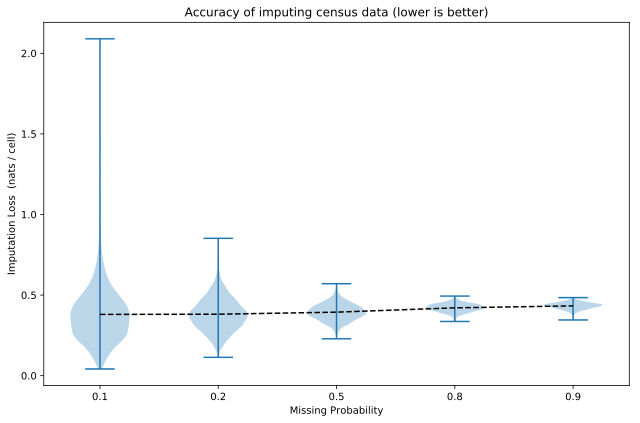

In [3]:
pyplot.figure(figsize=(9, 6))
keys = list(sorted(losses.keys(), reverse=True))
X = list(range(1, 1 + len(losses)))
Y = [np.mean(losses[key]) for key in keys]
pyplot.plot(X, Y, 'k--')
pyplot.violinplot([losses[key] for key in keys])
pyplot.xticks(X, labels=["{:0.2g}".format(1 - key) for key in keys])
pyplot.title("Accuracy of imputing {} data (lower is better)".format(args.dataset))
pyplot.xlabel("Missing Probability")
pyplot.ylabel("Imputation Loss  (nats / cell)")
pyplot.tight_layout()